# 'Imaka WFS Characterization

#### Goals:

(1) Animate WFS images on nightly basis (done in other notebook)

(2) Calculate SNR from circular buffer data

#### Here, I will consider three sources of noise in the SNR calculation:

$\textbf{Shot noise (source):}$ inherent statistical variation in the arrival rate of photons incident on the CCD from the source

$\textbf{Shot noise (sky):}$ same as previous, but background photons rather than source photons

$\textbf{Read noise:}$ inherent system noise of the instrument processing the signal

These contributions come together in the following way:

$$SNR = \frac{R_* \times t}{[(R_* \times t)+(R_{sky} \times t\times n_{pix})
+(RN^2 + (\frac{G}{2})^2\times n_{pix})+(D\times n_{pix}\times t)]^{1/2}}$$

Note: there is also technically a contribution from the $\textbf{dark noise}$, which arises from electrons thermally generated within the CCD, independent of photon-induced signal.  However, because dark noise is typically not an issue in CCDs and Mark says in our instruments it is negligible, we will not consider it in this analysis.

## Read Noise

Read noise is defined such that $\textrm{(RN)}^2$ readouot (e-) within an area of $n_{pix}$ is:
$$\sigma_{RN}=\sqrt{n_{pix}\times RN^2}$$

To measure this, we assume that the contribution to non-illuminated subapertures by dark noise is negligible, and therefore the signal is pureley read noise. 

For a single 'aocbXXX.fits' file: using the raw WFS data (index 1 in fits files) median combine into one stack, and then remove illuminated subapertures to create a completely unilluminated image. Take median and standard deviation. Call this the read noise per pixel, $\textrm{(RN)}^2$.

Complication: if the gain is not one, then there's an additional term. I think that this can only be applied if working in electron counts, not ADU; check back with Mark on conversion numbers.
$$\sigma_{RN}=\sqrt{RN^2 \times (\frac{G}{2})^2\times n_{pix}}$$

Additionally: took median, mean and standard deviation on a pixel by pixel basis of all frames in one 'aocbXXXX.fits' file. (QUESTION: how to condense this data for a night in a meaningful way?)

In [48]:
ao_dir = "//g/lu/data/imaka/onaga/20170521/ao/"
WFS_num = 0
time, RN, RN_err = calc_RN(ao_dir, WFS_num)

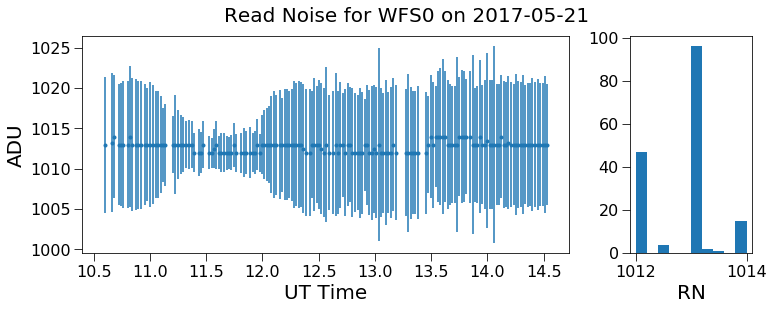

In [352]:
plot_RN(time, SNR)

$\textbf{Conclusions:}$ Based on the above plot, the read noise is ~1013 ADU per pixel, though the error on that number seemed to change over time in a regular way. For the purposes of calculating SNR in the following sections, I'll quote $(\textrm{RN})^2=1013$.

Additional ideas - mini experiment: take a series of darks (close dome and turn off lights) at a set of different exposure times.  Plot signal as a function of exposure time, fit to straight line (assuming linearity in dark noise) and the y-intercept should be the read noise. Additionally, this will check whether or not dark current is indeed negligible.

## Shot Noise

Shot noise (or Poisson noise, photon noise) is broken down into two components: (1) the contribution of the source, and (2) the contribution of the background sky.  For the source:
$$\sigma_*=\sqrt{R_* \times t}$$
Where $R_*$ is the rate of photo-electrons on the CCD and $t$ is the integration time.  For the sky, we have a similar equation:

$$\sigma_{sky}=\sqrt{R_{sky} \times t \times n_{pix}}$$
where $R_{sky}$ is now the rate of electrons produced by background photons per pixel on the CCD.

The scheme here will be to do aperture photometry on each subaperture. To do this, I'll: 

---stack all the frames of one 'aocbXXXX.fits' file 

---cut this image into a 8x8 grid and discard subapertures without spots

---fit the subaperture to a gaussian, for an estimation of FWHM 

---Use photutils to do aperture photometry and measure the flux of the spot

---Mask the spot based on above photometry and assume the rest of the subaperture is background

---Median combine the spot and sky signals for all subapertures.  This gives one measurment of each per 'aocbXXXX.fits' file 

QUESTION: What should be removed when?  E.g., should I do aperture photometry on subapertures after subtracting off read noise?  And should the spot flux have the sky removed first?  Right now I've done the latter, but not the former.  Does that mean I'm counting read noise twice?

In [286]:
files = glob(ao_dir+"aocb*.fits")
time, R_star, R_star_err, R_sky, R_sky_err = night_phot(files)

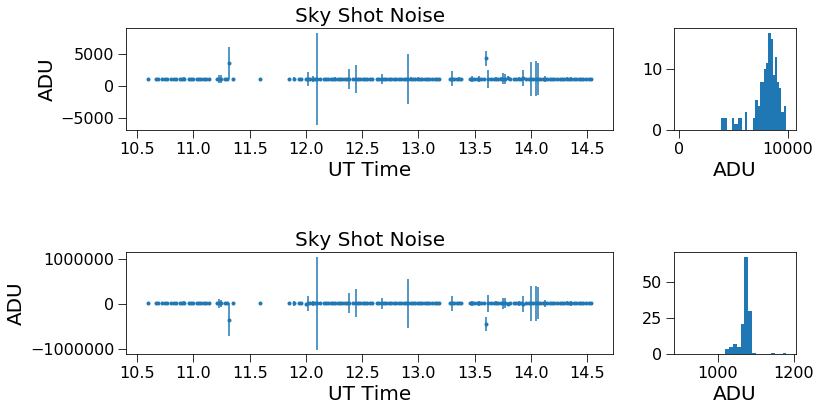

In [288]:
plot_shot(time, R_sky, R_sky_err, R_star, R_star_err)

Based on the medians of the data that is illustrated in the figures above, the signal from the source and sky are:
$$R_*=8255\: \textrm{e}^-$$
$$R_{sky}=1075\: \textrm{e}^-/\textrm{pix}$$


## Final SNR Calculation

With all of the above components, we can now calculate the SNR.  Note that rather than rates x times, we are using integrated fluxes.  The area $n_{pix}$ is the averaged area used in the individual instances of aperture photometry, 9.424.

Using the quoted results and equation above, I derived:
$$SNR = 49.4$$

The distribution between SNR of different circular buffers is shown below, as well as its variation with time.  The dip in SNR around 11.5 hrs corresponds to the decrease in standard deviation of RN in the first figure. In videos, this moment shows all spots dimming significantly, which might be why the photometry suffers (sparse data there) but I'm not sure why the RN would change. Maybe 'unillluminated' subapertures are getting some light?

QUESTION: Can put uncertainty on this with error propagation, assuming quantities are uncorrelated.  Which... is maybe dependent on the previous question about what to subtract where.

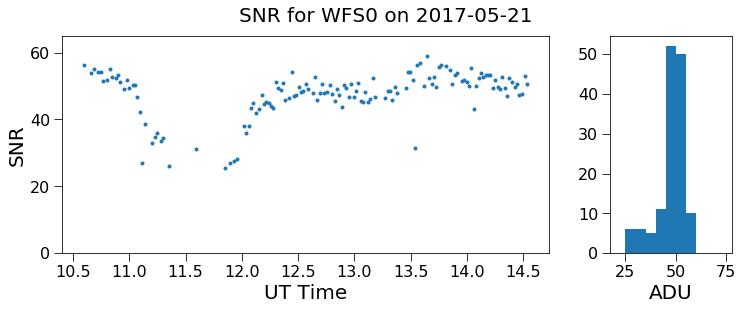

In [349]:
plot_SNR(time, SNR)

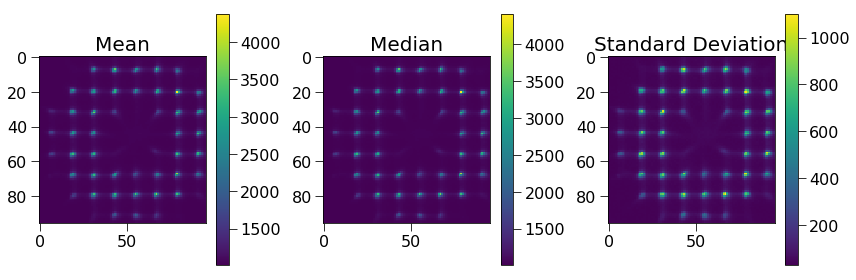

In [61]:
file = glob(ao_dir+"aocb*.fits")[0]
plot_wfs(file, 0)

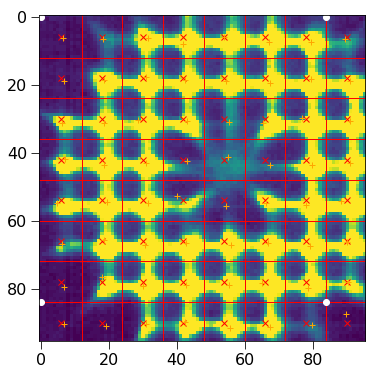

In [76]:
#aligning centroids

hdul = fits.open(file)
data_raw = hdul[1].data
data_cen = hdul[3].data
hdul.close()
img = data_raw[0][0]
cents = data_cen[0][0]
x = []
y = []
for i in range(64):
    x.append(cents[i * 2])
    y.append(cents[i * 2 + 1])

plt.figure(figsize=(6,6))
plt.imshow(stack, vmin=1010, vmax=1070)
[plt.axvline(_x, linewidth=1, color='r') for _x in [12,24,36,48, 60, 72, 84]]
[plt.axhline(_x, linewidth=1, color='r') for _x in [12,24,36,48, 60, 72, 84]];

for i in range(64):
    x_cent = (i//8)*12+6
    y_cent = (i%8)*12+6
    plt.plot(x_cent, y_cent, 'rx')
    plt.plot(x_cent+x[i], y_cent+y[i], '+', color='orange')
    if (i//8 in [0,7]) and (i%8 in [0,7]): #corners
        row = (i//8)*12
        col = (i%8)*12
        plt.plot(row, col, 'o', color='white')

In [310]:
import numpy as np
from glob import glob
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.animation as animation
from astropy.stats import sigma_clipped_stats
from photutils import datasets, DAOStarFinder, CircularAperture, SkyCircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import aperture_photometry
from astropy.modeling import models, fitting
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
%matplotlib inline

def get_cb(file):
    hdul = fits.open(file)
    raw_data = hdul[1].data
    hdul.close
    return raw_data

def plot_wfs(file, WFS_num):
    data_raw = get_cb(file)
    mean = np.mean(data_raw, axis=0)[WFS_num]
    med = np.median(data_raw, axis=0)[WFS_num]
    std = np.std(data_raw, axis=0)[WFS_num]
    plt.figure(1, figsize=(12,4))
    plt.subplot(131); plt.imshow(mean); plt.title('Mean'); plt.colorbar()
    plt.subplot(132); plt.imshow(med); plt.title('Median'); plt.colorbar()
    plt.subplot(133); plt.imshow(std); plt.title('Standard Deviation'); plt.colorbar()
    plt.tight_layout()
    return

def get_darks(img):
#Given one circular buffer image frame, returns a list of subapertures that aren't illuminated
    darks = []
    for i in range(64):
        if (i//8 in [0,7]) and (i%8 in [0,7]): #corners
            row = (i//8)*12
            col = (i%8)*12
            cut = img[row:row+12, col:col+12]
            darks.append(cut)
    return darks

def calc_RN(ao_dir, WFS_num):
    files = glob(ao_dir+"aocb*.fits")
    RN = []
    RN_err = []
    time = []
    for file in files:
        hdul = fits.open(file)
        data_raw = hdul[1].data
        t = hdul[0].header['OBSTIME']
        time.append(float(t))
        hdul.close()
        stack = np.median(data_raw, axis=0)[WFS_num] #All circular buffers median combined for 1 wfs
        dark = np.vstack(get_darks(stack)) #Make one 'image' of just the uniluminated subapertures
        RN.append(np.median(dark))
        RN_err.append(np.std(dark))
    return time, RN, RN_err

def get_spots(img):
#Given one circular buffer iamge frame, returns a list of subapertures that (in theory) are illuminated by spots
# Excludes corners, adjacent to corners, and center four subapertures
    cuts = []
    for i in range(64):
        if (i//8 in [0,7]) and (i%8 in [0,7]): #corners
            pass
        elif i in [1,6,8,15,55,48,57,62]: #adjacent to corners
            pass
        elif i in [27,28,35,36]: #inner four 
            pass
        else: 
            row = (i//8)*12
            col = (i%8)*12
            cut = img[row:row+12, col:col+12]
            cuts.append(cut)
    return cuts

def guess_fwhm(spot):
#Measures and approximate FWHM empirically for one subaperture spot
    half_max = np.max(spot)/2
    bright = np.where(spot>half_max)
    area = len(bright[0])
    FWHM = np.sqrt(area/2) *2
    return FWHM
        
def spot_phot(spot):
#Given one subaperture with a spot, estimates fwhm and location of spot and performs aperture photometry
#Returns total source flux (background subtracted) and sky signal per pixel
    FWHM = guess_fwhm(spot)
    x_cent = np.argmax(np.sum(spot, axis=0))
    y_cent = np.argmax(np.sum(spot, axis=1))

    position = (x_cent, y_cent)
    aperture = CircularAperture(position, r=FWHM/2)

    phot_table = aperture_photometry(spot, aperture)
    aper_flux = phot_table[0]['aperture_sum']
    aper_area = (np.pi * ((FWHM/2)**2))
    sky_pix = np.sum(spot) - aper_flux
    sky_area = (12*12) - aper_area
    sky = sky_pix / sky_area
    source = aper_flux - (sky * aper_area)
    
    return source, sky

def night_phot(files):
    #for a bunch of aocbXXXX.fits files, calculates median and std of sky and source signal
    #returns time array too
    time = []
    R_star = []
    R_star_err = []
    R_sky = []
    R_sky_err = []

    for file in files:    
        hdul = fits.open(file)
        raw_data = hdul[1].data
        t = hdul[0].header['OBSTIME']
        time.append(float(t))
        hdul.close()

        img = np.median(raw_data, axis=0)[WFS_num]
        spots = get_spots(img)

        source = []
        sky = []
        for spot in spots:
            sr, sk = spot_phot(spot)
            if sk > 0:
                source.append(sr)
                sky.append(sk)
        R_star.append(np.median(source))
        R_star_err.append(np.std(source))
        R_sky.append(np.median(sky))
        R_sky_err.append(np.std(sky))
        
    return time, R_star, R_star_err, R_sky, R_sky_err


def plot_shot(time, R_sky, R_sky_err, R_star, R_star_err):

    gs = GridSpec(2,4)
    fig = plt.figure(1, figsize=(12,6))


    ax1 = plt.subplot(gs[0,:-1])
    ax1.errorbar(time, R_sky, R_sky_err, fmt='.')
    ax1.xaxis.set_major_locator(ticker.MaxNLocator(10))
    ax1.set_ylabel('ADU'); ax1.set_xlabel('UT Time'); ax1.set_title('Sky Shot Noise');

    ax2 = plt.subplot(gs[1,:-1])
    ax2.errorbar(time, R_star, R_star_err, fmt='.')
    ax2.xaxis.set_major_locator(ticker.MaxNLocator(10))
    ax2.set_ylabel('ADU'); ax2.set_xlabel('UT Time'); ax2.set_title('Sky Shot Noise');

    ax3 = plt.subplot(gs[0,-1])

    ax3.hist(np.array(R_star)[~np.isnan(np.array(R_star))], bins=np.arange(0, max(R_star), 200))
    #ax3.xaxis.set_major_locator(ticker.MaxNLocator(10))
    ax3.set_xlabel('ADU'); #ax3.set_xlabel('UT Time'); ax1.set_title('Sky Shot Noise');

    ax4 = plt.subplot(gs[1,-1])
    ax4.hist(np.array(R_sky)[~np.isnan(np.array(R_sky))], bins=np.arange(900, 1200, 10));
    #ax4.xaxis.set_major_locator(ticker.MaxNLocator(10))
    ax4.set_xlabel('ADU');# ax3.set_xlabel('UT Time'); ax1.set_title('Sky Shot Noise');

    plt.subplots_adjust(hspace=1.2, wspace=0.5)

def plot_SNR(time, SNR):
    gs = GridSpec(1,4)
    fig = plt.figure(1, figsize=(12,4))


    ax1 = plt.subplot(gs[0,:-1])
    ax1.plot(time, SNR, '.')
    ax1.xaxis.set_major_locator(ticker.MaxNLocator(10))
    ax1.set_ylabel('SNR'); ax1.set_xlabel('UT Time'); 
    ax1.set_ylim([0, 65])

    ax3 = plt.subplot(gs[0,-1])
    ax3.hist(np.array(SNR)[~np.isnan(np.array(SNR))], bins=np.arange(20, 80, 5))#, bins=np.arange(0, max(SNR), 200))
    ax3.set_xlabel('ADU'); #ax3.set_xlabel('UT Time'); ax1.set_title('Sky Shot Noise');

    fig.suptitle('SNR for WFS0 on 2017-05-21', fontsize=20)
    plt.subplots_adjust(hspace=1.2, wspace=0.5)

    return


def plot_RN(time, SNR):
    gs = GridSpec(1,4)
    fig = plt.figure(1, figsize=(12,4))


    ax1 = plt.subplot(gs[0,:-1])
    ax1.errorbar(time, RN, RN_err, fmt='.')
    ax1.xaxis.set_major_locator(ticker.MaxNLocator(10))
    ax1.set_ylabel('ADU'); ax1.set_xlabel('UT Time'); 
    a#x1.set_ylim([0, 65])

    ax3 = plt.subplot(gs[0,-1])
    ax3.hist(np.array(RN)[~np.isnan(np.array(RN))])#, bins=np.arange(20, 80, 5))#, bins=np.arange(0, max(SNR), 200))
    ax3.set_xlabel('RN'); #ax3.set_xlabel('UT Time'); ax1.set_title('Sky Shot Noise');

    fig.suptitle('Read Noise for WFS0 on 2017-05-21', fontsize=20)
    plt.subplots_adjust(hspace=1.2, wspace=0.5)

    return

In [331]:
#plt.hist(area, bins=np.arange(0,25, 1))
area = np.nanmedian(area)

In [350]:
-Make animation for wfs over time to see drift, stretching

-looking at SNR, roughly N/sqrt(N+Background+readnoise)

-to get readnoise term for SNR, take dark pixels (not in an image square) and get mean, std, median (do on whole imgae, per pixel) (one circular buffer at a time)

- for background, same, but within subaperatures that have images

each sub apereture is 12x12. check: if you divide up each imgine into sub aperatures, does it stay one spot in each? if so, we can just do aperature photometry on each subaperature.  otherwise, the subaperatures will have to slide

ask about timestamps in circular buffers

KEEP IN MIND: what should we do with the instrument (experiments: darks, flats, exposure times

circular buffers re indicated in science imagae header; skys are with normal sky data


SyntaxError: invalid syntax (<ipython-input-350-ed485f66fe04>, line 1)